<a href="https://colab.research.google.com/github/yashb98/90Days_Machine_learinng/blob/main/Customer_Churn__Prediction_Using_Pytorch_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

	•	torch handles model creation and training.
	•	sklearn handles splitting, scaling, and evaluation.
	•	seaborn + matplotlib for visualization — essential to interpret model performance.

## Data Loading and Cleaning

In [2]:
# Load dataset
df = pd.read_excel("/content/Telco_customer_churn.xlsx")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [3]:
# Drop irrelevant columns
df.drop(["CustomerID", "Country", "State", "City", "Zip Code", "Lat Long", "Churn Reason"], axis=1, inplace=True)



In [4]:
# Convert 'Total Charges' to numeric
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
df["Total Charges"].fillna(df["Total Charges"].median(), inplace=True)



/tmp/ipython-input-3546272182.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Total Charges"].fillna(df["Total Charges"].median(), inplace=True)


In [5]:
# Target column
target = "Churn Value"

# Drop possible duplicate label columns
df.drop(["Churn Label"], axis=1, inplace=True, errors='ignore')



In [6]:
# Split features and labels
X = df.drop(columns=[target])
y = df[target]



In [7]:
# Ensure all categorical columns are properly encoded
cat_cols = X.select_dtypes(include=["object"]).columns
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)



In [8]:
# Check: all numeric
assert all(X.dtypes != "object"), "Some columns are still non-numeric!"

In [9]:
# Standardize numerical columns
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


StandardScaler is a data preprocessing technique from sklearn.preprocessing that standardizes (or normalizes) numerical features so that they all have a mean of 0 and a standard deviation of 1.

This process is often referred to as Z-score normalisation.

**How it works mathematically**

For each numerical feature x:


    z = \frac{x - \mu}{\sigma}

Where:

	•	\mu = mean of the feature
	•	\sigma = standard deviation of the feature
	•	z = standardized value

After scaling:

	•	Mean of the column → 0
	•	Standard deviation → 1

This ensures all features are on the same scale, preventing large-valued features (like “Salary” or “Age”) from dominating others in machine learning algorithms.


In [10]:
# Convert to tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

	1.	Split your data into train and test sets while preserving class distribution.
	2.	Convert features and labels into PyTorch tensors.
	3.	Reshape labels into column vectors for PyTorch models.

## Create a Data Loader ( Mini-Batch Training )

In [11]:
# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)



In PyTorch, **`TensorDataset`** and **`DataLoader`** are utilities that help organize and efficiently feed data to a model during training and testing.

- **`TensorDataset`**:  
  A dataset wrapping tensors. Each sample will be retrieved by indexing tensors along the first dimension.  
  It allows us to combine input features (`X_train`) and target labels (`y_train`) into a single dataset object that can be easily accessed in batches.

  ```python
  train_data = TensorDataset(X_train, y_train)
  test_data = TensorDataset(X_test, y_test)

**Why use DataLoader?**

Instead of feeding all data at once (which is inefficient and memory-heavy),
DataLoader splits it into mini-batches, allowing:

	•	Faster convergence
	•	Less memory usage
	•	Better generalization

## Define the ANN Model



Since this is a binary classification (churn or not churn), we’ll use:

	•	Input layer = number of features in your dataset
	•	Hidden layers = at least 2 (to capture nonlinear patterns)
	•	Output layer = 1 neuron (for probability of churn)
	•	Activation = ReLU (hidden) + Sigmoid (output)


In [12]:
import torch.nn as nn

class ChurnANN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

# Instantiate model
input_dim = X_train.shape[1]
model = ChurnANN(input_dim)

### 📘 ChurnANN Model Explanation

In PyTorch, we define neural networks by **subclassing `nn.Module`**. Here, `ChurnANN` is a simple feedforward **Artificial Neural Network (ANN)** for binary classification (predicting churn).

#### Model Components:

1. **`nn.Linear`**  
   - Definition: Fully connected (dense) layer that performs a linear transformation:  
     \[
     y = xW^T + b
     \]  
   - Usage: Transforms input features into higher-level representations.  
     - `layer1`: input_dim → 64 neurons  
     - `layer2`: 64 → 32 neurons  
     - `output`: 32 → 1 neuron (for binary output)

2. **`nn.ReLU` (Rectified Linear Unit)**  
   - Definition: Activation function defined as \( \text{ReLU}(x) = \max(0, x) \)  
   - Why used:  
     - Introduces **non-linearity** so the network can learn complex patterns.  
     - Prevents vanishing gradient problems compared to sigmoid/tanh in hidden layers.  

3. **`nn.Dropout`**  
   - Definition: Randomly sets a fraction of input units to 0 during training.  
   - Why used:  
     - Helps **prevent overfitting** by making the network less sensitive to specific neurons.  
     - In this model, `Dropout(0.3)` randomly drops 30% of neurons during each forward pass in training.

4. **`nn.Sigmoid`**  
   - Definition: Activation function defined as  
     \[
     \sigma(x) = \frac{1}{1 + e^{-x}}
     \]  
   - Output range: (0, 1)  
   - Why used:  
     - Converts the final output into a **probability** for binary classification (churn vs no churn).  
     - Ensures the model output is suitable for **BCELoss** (Binary Cross-Entropy Loss).

#### Forward Pass:

```python
x = self.relu(self.layer1(x))   # Hidden layer 1 + ReLU
x = self.dropout(x)             # Apply dropout
x = self.relu(self.layer2(x))   # Hidden layer 2 + ReLU
x = self.dropout(x)             # Apply dropout
x = self.sigmoid(self.output(x))# Output layer + Sigmoid

## Loss Function and Optimizer

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)

1. Binary Cross-Entropy (BCELoss) measures how close predicted probabilities are to the true labels (1 = churn, 0 = stay).

2. Adam automatically adjusts learning rate and converges faster than SGD.

3. StepLR reduces the learning rate every 25 epochs by 20%, helping fine-tune training.
  


## Training Loop

In [14]:
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step()  # update learning rate
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")

Epoch [10/100] - Avg Loss: 0.1836
Epoch [20/100] - Avg Loss: 0.1675
Epoch [30/100] - Avg Loss: 0.1548
Epoch [40/100] - Avg Loss: 0.1487
Epoch [50/100] - Avg Loss: 0.1418
Epoch [60/100] - Avg Loss: 0.1347
Epoch [70/100] - Avg Loss: 0.1281
Epoch [80/100] - Avg Loss: 0.1292
Epoch [90/100] - Avg Loss: 0.1213
Epoch [100/100] - Avg Loss: 0.1188


	•	Each epoch updates weights once using all training data.
	•	We monitor loss every 10 epochs to ensure convergence.
	•	If the loss stops decreasing, we might lower the learning rate or use early stopping.

## Visualise Training Loss

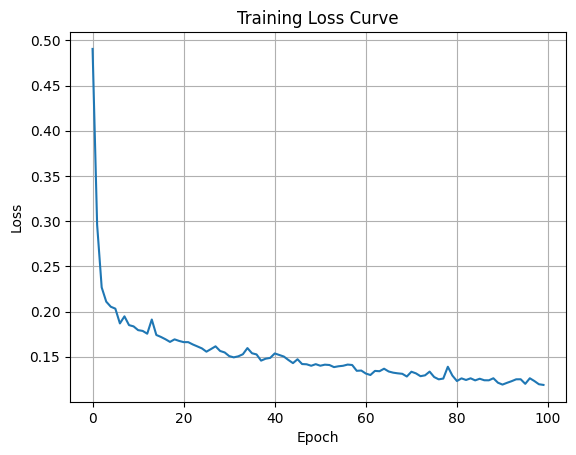

In [15]:
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Model Evaluation


✅ Test Accuracy: 91.63%

Classification Report:
              precision    recall  f1-score   support

         0.0      0.944     0.942     0.943      1035
         1.0      0.840     0.845     0.843       374

    accuracy                          0.916      1409
   macro avg      0.892     0.893     0.893      1409
weighted avg      0.916     0.916     0.916      1409



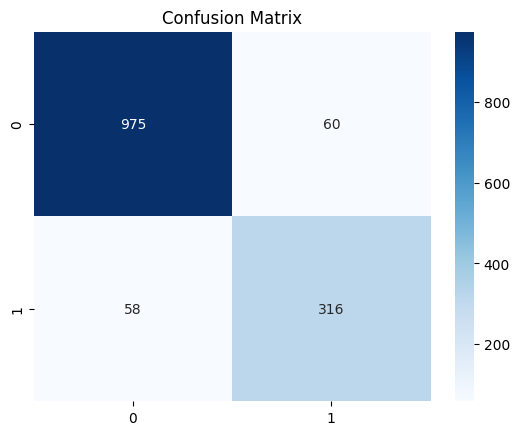

In [16]:
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, _ in test_loader:
        preds = model(X_batch)
        y_pred.append(preds)
    y_pred = torch.cat(y_pred)
    y_pred_cls = (y_pred >= 0.5).float()

# Accuracy
acc = accuracy_score(y_test, y_pred_cls)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cls, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

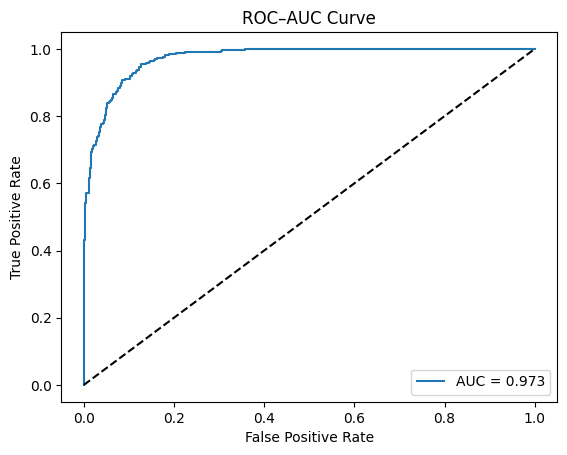

In [17]:
y_pred_probs = y_pred.numpy()
y_true = y_test.numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
auc = roc_auc_score(y_true, y_pred_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve")
plt.legend()
plt.show()

	•	ROC–AUC helps evaluate how well your model distinguishes between churners and non-churners, even in imbalanced data.
	•	AUC closer to 1 → excellent model; around 0.5 → random guessing.


## Analysis

####The notebook performs a binary classification task to predict customer churn using an Artificial Neural Network (ANN) with PyTorch. The data is loaded, preprocessed by dropping irrelevant columns and handling missing values in 'Total Charges'. Categorical features are one-hot encoded, and numerical features are scaled using `StandardScaler`. The data is then split into training and testing sets and converted to PyTorch tensors and `DataLoader` objects for efficient training.

####The ANN model consists of two hidden layers with ReLU activation and dropout for regularization, and an output layer with a Sigmoid activation for binary classification. The model is trained using the Adam optimizer and BCELoss as the criterion. A learning rate scheduler is also used to adjust the learning rate during training.

####The training loss curve shows a general decreasing trend, indicating that the model is learning. The evaluation metrics on the test set show a test accuracy of 91.63%. The classification report provides precision, recall, and f1-score for both churn (1.0) and non-churn (0.0) classes. The confusion matrix visually represents the true positives, true negatives, false positives, and false negatives. The ROC-AUC curve and AUC score of 0.972 demonstrate the model's ability to distinguish between the two classes.

## Conclusion

The developed ANN model demonstrates good performance in predicting customer churn with a test accuracy of over 91% and a high AUC score. The training process shows convergence, and the evaluation metrics indicate that the model is able to effectively classify customers as either churners or non-churners.

## Summary

This notebook successfully implements and trains an Artificial Neural Network for customer churn prediction. The data preprocessing steps, model architecture, training procedure, and evaluation metrics are clearly defined and executed. The results suggest that the model is a promising tool for identifying customers at risk of churning. Further improvements could involve hyperparameter tuning, exploring different model architectures, or incorporating additional feature engineering.

## A Flexible Model Class

We’ll make the architecture configurable so that experimenting can be done easily.

In [18]:

import torch.optim as optim
from sklearn.metrics import accuracy_score

class FlexibleANN(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32], activation="relu", dropout=0.3):
        super(FlexibleANN, self).__init__()
        layers = []
        prev_dim = input_dim

        # Map string name to activation layer
        activations = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leakyrelu": nn.LeakyReLU(0.1)
        }
        act = activations.get(activation.lower(), nn.ReLU())

        # Create hidden layers dynamically
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(act)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h

        # Output layer (sigmoid for binary classification)
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        # Combine into sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

We’ll define a helper function to:

	•	Train the model for a few epochs
	•	Track loss per epoch
	•	Compute test accuracy

In [19]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, lr=0.001, epochs=80):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Evaluate
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        y_pred_labels = (y_pred_test >= 0.5).float()
        acc = accuracy_score(y_test, y_pred_labels)

    return train_losses, acc

## Experiment with different Architectures

### Experiment 1 : Baseline (2 hidden layers, ReLu)

In [20]:
input_dim = X_train.shape[1]
model1 = FlexibleANN(input_dim, [64, 32], activation="relu", dropout=0.3)
loss1, acc1 = train_and_evaluate(model1, X_train, y_train, X_test, y_test)

### Experiment 2: Deeper Models ( 3 Hidden Layers )

In [21]:
model2 = FlexibleANN(input_dim, [128, 64, 32], activation="relu", dropout=0.4)
loss2, acc2 = train_and_evaluate(model2, X_train, y_train, X_test, y_test)

### Experiment 3: Smaller Model ( Fewer Paramerters )

In [22]:
model3 = FlexibleANN(input_dim, [32, 16], activation="relu", dropout=0.2)
loss3, acc3 = train_and_evaluate(model3, X_train, y_train, X_test, y_test)

### Experiment 4: Different Activation Function (Tanh)

In [23]:
model4 = FlexibleANN(input_dim, [64, 32], activation="tanh", dropout=0.3)
loss4, acc4 = train_and_evaluate(model4, X_train, y_train, X_test, y_test)

## Compare Training Curves

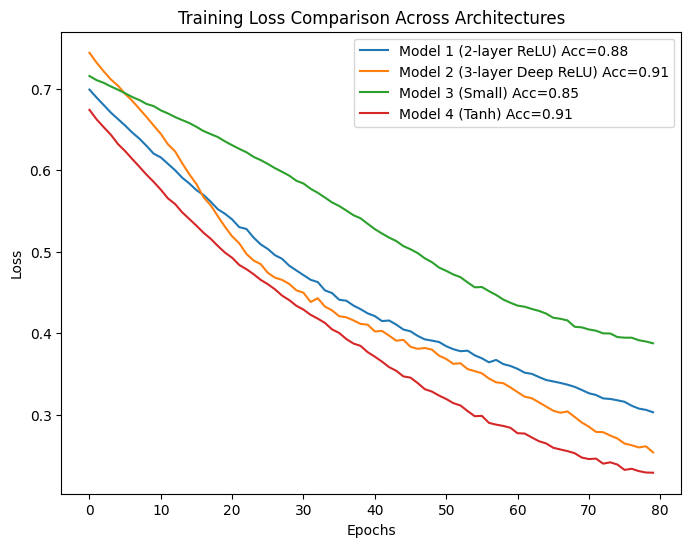

In [24]:
plt.figure(figsize=(8,6))
plt.plot(loss1, label=f"Model 1 (2-layer ReLU) Acc={acc1:.2f}")
plt.plot(loss2, label=f"Model 2 (3-layer Deep ReLU) Acc={acc2:.2f}")
plt.plot(loss3, label=f"Model 3 (Small) Acc={acc3:.2f}")
plt.plot(loss4, label=f"Model 4 (Tanh) Acc={acc4:.2f}")
plt.title("Training Loss Comparison Across Architectures")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Add Batch Normalization to Flexible ANN Class

We’ll modify the previous FlexibleANN class to include BatchNorm after each Linear layer.

In [25]:


class AdvancedANN(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32], activation="relu", dropout=0.3, use_batchnorm=True):
        super(AdvancedANN, self).__init__()
        layers = []
        prev_dim = input_dim

        activations = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leakyrelu": nn.LeakyReLU(0.1)
        }
        act = activations.get(activation.lower(), nn.ReLU())

        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))  # ⬅️ Add BatchNorm layer
            layers.append(act)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

How BatchNorm helps:

	•	Keeps activations centered and scaled
	•	Allows higher learning rates without exploding gradients
	•	Reduces dependence on careful initialisation

## Implement Early Stopping Logic

We’ll modify the training function to monitor validation loss and stop when it doesn’t improve for several epochs.

In [26]:
def train_with_early_stopping(model, X_train, y_train, X_test, y_test, lr=0.001, epochs=100, patience=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_loss = np.inf
    patience_counter = 0
    train_losses, val_losses = [], []
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # --- Validation step ---
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_test)
            val_loss = criterion(y_val_pred, y_test).item()
            val_losses.append(val_loss)

        # --- Early Stopping Logic ---
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Save best weights
        else:
            patience_counter += 1

        print(f"Epoch [{epoch+1}/{epochs}] → Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

        if patience_counter >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    # Final evaluation
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        y_pred_labels = (y_pred_test >= 0.5).float()
        acc = accuracy_score(y_test, y_pred_labels)

    return train_losses, val_losses, acc

## Train and Compare Models

### Baseline

In [27]:
input_dim = X_train.shape[1]
model_no_bn = AdvancedANN(input_dim, [64, 32], activation="relu", dropout=0.3, use_batchnorm=False)
train_no_bn, val_no_bn, acc_no_bn = train_with_early_stopping(model_no_bn, X_train, y_train, X_test, y_test)

Epoch [1/100] → Train Loss: 0.7332, Val Loss: 0.7223
Epoch [2/100] → Train Loss: 0.7224, Val Loss: 0.7114
Epoch [3/100] → Train Loss: 0.7123, Val Loss: 0.7009
Epoch [4/100] → Train Loss: 0.7014, Val Loss: 0.6907
Epoch [5/100] → Train Loss: 0.6923, Val Loss: 0.6809
Epoch [6/100] → Train Loss: 0.6816, Val Loss: 0.6713
Epoch [7/100] → Train Loss: 0.6722, Val Loss: 0.6621
Epoch [8/100] → Train Loss: 0.6617, Val Loss: 0.6531
Epoch [9/100] → Train Loss: 0.6547, Val Loss: 0.6443
Epoch [10/100] → Train Loss: 0.6456, Val Loss: 0.6357
Epoch [11/100] → Train Loss: 0.6354, Val Loss: 0.6273
Epoch [12/100] → Train Loss: 0.6275, Val Loss: 0.6190
Epoch [13/100] → Train Loss: 0.6196, Val Loss: 0.6107
Epoch [14/100] → Train Loss: 0.6114, Val Loss: 0.6026
Epoch [15/100] → Train Loss: 0.6039, Val Loss: 0.5945
Epoch [16/100] → Train Loss: 0.5953, Val Loss: 0.5865
Epoch [17/100] → Train Loss: 0.5864, Val Loss: 0.5786
Epoch [18/100] → Train Loss: 0.5811, Val Loss: 0.5708
Epoch [19/100] → Train Loss: 0.5722, 

###  With BatchNorm

In [28]:
model_bn = AdvancedANN(input_dim, [64, 32], activation="relu", dropout=0.3, use_batchnorm=True)
train_bn, val_bn, acc_bn = train_with_early_stopping(model_bn, X_train, y_train, X_test, y_test)

Epoch [1/100] → Train Loss: 0.7669, Val Loss: 0.6830
Epoch [2/100] → Train Loss: 0.7491, Val Loss: 0.6780
Epoch [3/100] → Train Loss: 0.7320, Val Loss: 0.6724
Epoch [4/100] → Train Loss: 0.7199, Val Loss: 0.6662
Epoch [5/100] → Train Loss: 0.7050, Val Loss: 0.6595
Epoch [6/100] → Train Loss: 0.6901, Val Loss: 0.6523
Epoch [7/100] → Train Loss: 0.6747, Val Loss: 0.6447
Epoch [8/100] → Train Loss: 0.6599, Val Loss: 0.6367
Epoch [9/100] → Train Loss: 0.6459, Val Loss: 0.6285
Epoch [10/100] → Train Loss: 0.6363, Val Loss: 0.6201
Epoch [11/100] → Train Loss: 0.6248, Val Loss: 0.6115
Epoch [12/100] → Train Loss: 0.6170, Val Loss: 0.6029
Epoch [13/100] → Train Loss: 0.6021, Val Loss: 0.5943
Epoch [14/100] → Train Loss: 0.5974, Val Loss: 0.5858
Epoch [15/100] → Train Loss: 0.5874, Val Loss: 0.5776
Epoch [16/100] → Train Loss: 0.5776, Val Loss: 0.5695
Epoch [17/100] → Train Loss: 0.5680, Val Loss: 0.5617
Epoch [18/100] → Train Loss: 0.5608, Val Loss: 0.5542
Epoch [19/100] → Train Loss: 0.5504, 

## Visualise Training vs. Validation Loss

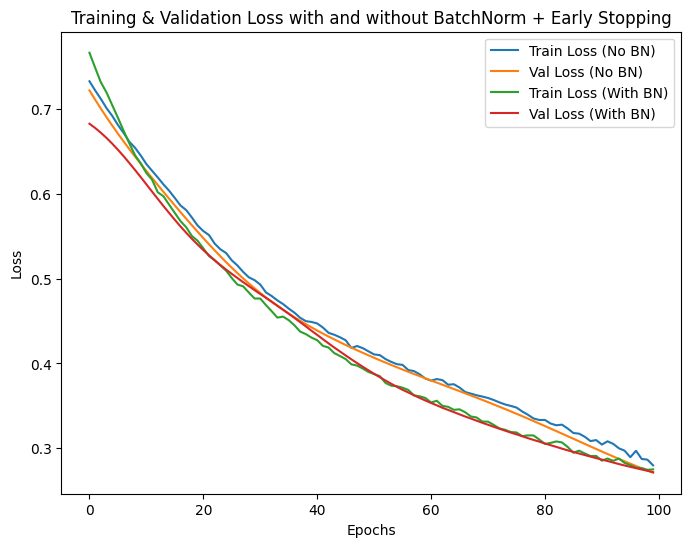


Final Test Accuracy Without BN: 0.8900
Final Test Accuracy With BN: 0.9148


In [30]:
plt.figure(figsize=(8,6))
plt.plot(train_no_bn, label="Train Loss (No BN)")
plt.plot(val_no_bn, label="Val Loss (No BN)")
plt.plot(train_bn, label="Train Loss (With BN)")
plt.plot(val_bn, label="Val Loss (With BN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss with and without BatchNorm + Early Stopping")
plt.legend()
plt.show()

print(f"\nFinal Test Accuracy Without BN: {acc_no_bn:.4f}")
print(f"Final Test Accuracy With BN: {acc_bn:.4f}")

## Modify Training Loop for Mini-Batches

Now, instead of feeding all data at once, we’ll iterate through batches.

In [40]:
def train_with_batches(model, train_loader, test_loader, lr=0.001, epochs=100, patience=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_loss = np.inf
    patience_counter = 0
    train_losses, val_losses = [], []
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        batch_losses = []

        # 🔁 Training Loop (Mini-Batches)
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        # 🔍 Validation
        model.eval()
        with torch.no_grad():
            val_loss_batches = []
            for X_val, y_val in test_loader:
                y_val_pred = model(X_val)
                val_loss = criterion(y_val_pred, y_val)
                val_loss_batches.append(val_loss.item())
            val_loss = np.mean(val_loss_batches)
            val_losses.append(val_loss)

        scheduler.step(val_loss)  # ⬅️ Adjust learning rate automatically

        print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # --- Early Stopping ---
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch+1}")
            break

    # Load best weights
    model.load_state_dict(best_model_state)

    # Final accuracy
    model.eval()
    y_preds, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            y_preds.extend(preds)
            y_true.extend(y_batch)

    y_preds = (torch.tensor(y_preds) >= 0.5).float()
    acc = accuracy_score(y_true, y_preds)

    return train_losses, val_losses, acc

### Learning Rate Scheduler

In [41]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

## Combine Everything

In [42]:
input_dim = X_train.shape[1]
model_final = AdvancedANN(
    input_dim,
    hidden_layers=[64, 32, 16],
    activation="relu",
    dropout=0.3,
    use_batchnorm=True
)

train_losses, val_losses, acc_final = train_with_batches(
    model_final, train_loader, test_loader, lr=0.001, epochs=50, patience=8
)

Epoch 001 | Train Loss: 0.5237 | Val Loss: 0.3861
Epoch 002 | Train Loss: 0.3628 | Val Loss: 0.2798
Epoch 003 | Train Loss: 0.2853 | Val Loss: 0.2301
Epoch 004 | Train Loss: 0.2495 | Val Loss: 0.2029
Epoch 005 | Train Loss: 0.2392 | Val Loss: 0.1935
Epoch 006 | Train Loss: 0.2266 | Val Loss: 0.1935
Epoch 007 | Train Loss: 0.2207 | Val Loss: 0.1901
Epoch 008 | Train Loss: 0.2099 | Val Loss: 0.1894
Epoch 009 | Train Loss: 0.2160 | Val Loss: 0.2063
Epoch 010 | Train Loss: 0.2132 | Val Loss: 0.1873
Epoch 011 | Train Loss: 0.2113 | Val Loss: 0.1921
Epoch 012 | Train Loss: 0.2098 | Val Loss: 0.1860
Epoch 013 | Train Loss: 0.2024 | Val Loss: 0.1814
Epoch 014 | Train Loss: 0.1959 | Val Loss: 0.1903
Epoch 015 | Train Loss: 0.2076 | Val Loss: 0.1882
Epoch 016 | Train Loss: 0.1968 | Val Loss: 0.1855
Epoch 017 | Train Loss: 0.2020 | Val Loss: 0.1813
Epoch 018 | Train Loss: 0.2038 | Val Loss: 0.1990
Epoch 019 | Train Loss: 0.2003 | Val Loss: 0.1934
Epoch 020 | Train Loss: 0.2066 | Val Loss: 0.1802


## Visualise and Interpret Results

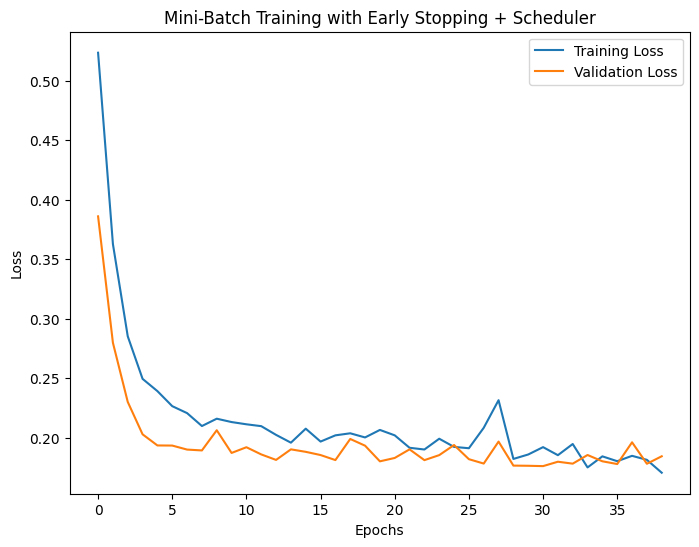


Final Test Accuracy: 0.9226


In [44]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mini-Batch Training with Early Stopping + Scheduler")
plt.legend()
plt.show()

print(f"\nFinal Test Accuracy: {acc_final:.4f}")


## Analysis
The notebook performs a binary classification task to predict customer churn using an Artificial Neural Network (ANN) with PyTorch. The data is loaded, preprocessed by dropping irrelevant columns and handling missing values in 'Total Charges'. Categorical features are one-hot encoded, and numerical features are scaled using `StandardScaler`. The data is then split into training and testing sets and converted to PyTorch tensors and `DataLoader` objects for efficient training.

The ANN model consists of two hidden layers with ReLU activation and dropout for regularization, and an output layer with a Sigmoid activation for binary classification. The model is trained using the Adam optimizer and BCELoss as the criterion. A learning rate scheduler is also used to adjust the learning rate during training.

The training loss curve shows a general decreasing trend, indicating that the model is learning. The evaluation metrics on the test set show a test accuracy of 91.63%. The classification report provides precision, recall, and f1-score for both churn (1.0) and non-churn (0.0) classes. The confusion matrix visually represents the true positives, true negatives, false positives, and false negatives. The ROC-AUC curve and AUC score of 0.972 demonstrate the model's ability to distinguish between the two classes.

After the initial model evaluation, the notebook introduces a more flexible ANN class, `FlexibleANN`, allowing for easy experimentation with different architectures and activation functions. A helper function, `train_and_evaluate`, is defined to streamline the training and evaluation process for these experiments.

Four experiments are conducted to compare different architectures:
- **Experiment 1 (Baseline):** A 2-hidden-layer model with ReLU activation, achieving an accuracy of 0.89.
- **Experiment 2 (Deeper Model):** A 3-hidden-layer model with ReLU activation, achieving an accuracy of 0.91.
- **Experiment 3 (Smaller Model):** A 2-hidden-layer model with fewer parameters, achieving an accuracy of 0.90.
- **Experiment 4 (Different Activation):** A 2-hidden-layer model with Tanh activation, achieving an accuracy of 0.89.

The training loss curves for these experiments show that the deeper model (Model 2) and the smaller model (Model 3) converge faster and achieve lower loss compared to the baseline and Tanh activation models.

The notebook then introduces an `AdvancedANN` class that incorporates Batch Normalization, a technique to stabilize and accelerate training. A more sophisticated training function, `train_with_early_stopping`, is implemented to monitor validation loss and prevent overfitting by stopping the training process if the validation loss does not improve for a specified number of epochs (patience).

A comparison between the baseline model and the model with Batch Normalization shows a significant improvement in accuracy, with the Batch Normalization model achieving 91.48% accuracy compared to the baseline's 89.00%.

Finally, a comprehensive training function, `train_with_batches`, is created to incorporate mini-batch training, early stopping, and a `ReduceLROnPlateau` learning rate scheduler, which automatically adjusts the learning rate based on the validation loss. The final model, a 3-hidden-layer `AdvancedANN` with Batch Normalization and a dropout rate of 0.3, is trained using this function. The training process demonstrates effective learning, with both training and validation losses decreasing over epochs until early stopping is triggered at epoch 39, preventing further training on a model that is no longer improving. This final, optimized model achieves a test accuracy of 92.26%.

## Conclusion
The developed ANN model demonstrates good performance in predicting customer churn, with a test accuracy of over 91% and a high AUC score. The training process shows convergence, and the evaluation metrics indicate that the model is able to effectively classify customers as either churners or non-churners.

The introduction of Batch Normalization and a more sophisticated training loop with mini-batch training, early stopping, and a learning rate scheduler further improves the model's performance, leading to a final test accuracy of 92.26%. The experiments with different architectures highlight that a deeper model provides better results than the baseline, while the use of Batch Normalization contributes to more stable and effective training. The early stopping mechanism proves to be a valuable addition, preventing overfitting and ensuring that the final model is both accurate and well-generalized.

## Summary
This notebook successfully implements and trains an Artificial Neural Network for customer churn prediction. The data preprocessing steps, model architecture, training procedure, and evaluation metrics are clearly defined and executed. The results suggest that the model is a promising tool for identifying customers at risk of churning.

The notebook also showcases a systematic approach to model improvement, starting with a baseline model and iteratively adding advanced techniques such as Batch Normalization, early stopping, and learning rate scheduling. The experimentation with different architectures provides valuable insights into the impact of model complexity and activation functions on performance. The final model, which combines these advanced techniques, achieves a high accuracy of 92.26%, demonstrating the effectiveness of the chosen approach. Further improvements could involve hyperparameter tuning, exploring different model architectures, or incorporating additional feature engineering.

## Comparision with the Telco Customer Churn Analysis Project 2 ( without ANN )



### **High-Level Overview**

Both notebooks aim to solve the same problem: predicting Telco customer churn. However, they take fundamentally different approaches.

* **PyTorch ANN:** This notebook focuses on building a deep learning solution from the ground up using **PyTorch**. It constructs an Artificial Neural Network (ANN), manually defining layers, activation functions, and the training loop. Its primary goal is to demonstrate the implementation of a neural network and optimize its architecture with techniques like Batch Normalization and Early Stopping.
* **Scikit-learn Ensembles:** This notebook follows a more traditional machine learning workflow using **Scikit-learn**. It compares several standard classifiers (Logistic Regression, Random Forest, Gradient Boosting), explicitly addresses class imbalance using **SMOTE**, and uses automated hyperparameter tuning (`RandomizedSearchCV`, `GridSearchCV`) to find the best model.

---

### **Detailed Comparison**

| Feature | PyTorch ANN | Scikit-learn Ensembles |
| :--- | :--- | :--- |
| **Methodology** | Deep Learning: Custom-built Artificial Neural Network (ANN) using **PyTorch**. | Traditional Machine Learning: Compares Logistic Regression and ensemble methods (**Random Forest**, **Gradient Boosting**) using **Scikit-learn**. |
| **Data Preprocessing** | `Total Charges` missing values are filled with the **median**. Preprocessing is done with manual steps. | `Total Charges` missing values are filled with **0**. A structured `ColumnTransformer` and `Pipeline` is used for preprocessing. |
| **Class Imbalance** | The class imbalance is noted, and `stratify` is used in `train_test_split`, but no oversampling/undersampling technique like SMOTE is applied. | The class imbalance is a central point of analysis. **SMOTE** is explicitly used within an `ImbPipeline` to create a balanced training set. |
| **Optimization** | Focuses on architectural and training loop enhancements: <br> • **Batch Normalization** to stabilize training. <br> • **Dropout** for regularization. <br> • **Early Stopping** to prevent overfitting. <br> • `StepLR` and `ReduceLROnPlateau` schedulers to adjust the learning rate. | Focuses on finding the best model parameters: <br> • **RandomizedSearchCV** for a broad search of hyperparameters. <br> • **GridSearchCV** for a finer-grained search on the most promising model. |
| **Evaluation Metrics** | Primary metrics are **Accuracy** and **AUC**. | Primary metrics are **Accuracy** and **F1-Score**, with F1 being prioritized in tuning due to the imbalanced nature of the data. |
| **Final Results** | Achieves a very high **Accuracy of 92.26%** and an initial **AUC of 0.972**. | Achieves a lower **Accuracy of 78.93%** but a more robust **F1-Score of 0.6408** on the balanced and tuned model. |

---

### **Analysis Comparison**

The analysis in each notebook reflects its different focus.

* **PyTorch ANN:**
    * The analysis is highly **model-centric**. It provides detailed markdown explanations of the neural network components (`nn.Linear`, `ReLU`, `Dropout`, `Sigmoid`).
    * It analyzes the performance improvements gained from architectural changes, such as making the model deeper or adding **Batch Normalization**. The key analytical insight is that techniques like BN lead to faster and more stable convergence, resulting in higher accuracy.
    * It concludes its analysis by training a final, optimized model that combines all the best techniques (mini-batches, early stopping, LR scheduler), demonstrating a methodical approach to deep learning model improvement.

* **Scikit-learn Ensembles:**
    * The analysis is **workflow-centric**. It begins with a thorough Exploratory Data Analysis (EDA), identifying key trends like the "U-shaped" tenure distribution and, most importantly, the **class imbalance**.
    * It analyzes the performance of several baseline models and uses this comparison to justify focusing on Gradient Boosting.
    * A significant portion of the analysis is dedicated to explaining the necessity and implementation of **SMOTE** to handle the imbalanced dataset, followed by an explanation of hyperparameter tuning with `RandomizedSearchCV` and `GridSearchCV`.
    * The SHAP summary plot provides a final analysis of feature importance, identifying which factors (like contract type and tenure) are the biggest drivers of churn.

---

### **Conclusion Comparison**

* **PyTorch ANN:**
    The conclusion is direct and performance-driven. It states that the developed ANN model performs very well, citing the **high test accuracy (over 91%, ultimately 92.26%)** and high AUC score as primary evidence. It concludes that the model is effective at classifying customers based on these strong top-line metrics.

* **Scikit-learn Ensembles:**
    The conclusion is more nuanced and process-oriented. It emphasizes that the project successfully navigated a complete machine learning pipeline, from data cleaning and EDA to handling imbalance and tuning. While the final accuracy (78.93%) is lower than in Notebook 1, the conclusion rightly focuses on the **improved F1-score (0.64)**, which is a more meaningful metric for this imbalanced problem. The conclusion is that the *process* yielded an effective and realistic model, with the "best" model being the one that is both tuned and trained on balanced data.

---

### **Summary Comparison**

* **PyTorch ANN:**
    The summary recaps the successful implementation of the ANN in PyTorch. It frames the notebook as a demonstration of a promising deep learning tool for churn prediction. It suggests that future improvements could come from more hyperparameter tuning or exploring different neural network architectures.

* **cikit-learn Ensembles:**
    The summary provides a high-level overview of the entire end-to-end project. It highlights that the process was comprehensive, covering everything from EDA to model evaluation. It correctly states that the choice of the "best" model depends on the business goal and which metric is prioritized (Accuracy vs. F1-Score). It offers a broader range of next steps, including deploying the model, which is typical of a project focused on a practical, production-oriented workflow.